# grg

In [1]:
gpu_info = !nvidia-smi
gpu_info = '\n'.join(gpu_info)
if gpu_info.find('failed') >= 0:
  print('Not connected to a GPU')
else:
  print(gpu_info)

Not connected to a GPU


In [2]:
from google.colab import drive
import pandas as pd
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [3]:
from psutil import virtual_memory
ram_gb = virtual_memory().total / 1e9
print('Your runtime has {:.1f} gigabytes of available RAM\n'.format(ram_gb))

if ram_gb < 20:
  print('Not using a high-RAM runtime')
else:
  print('You are using a high-RAM runtime!')

Your runtime has 13.6 gigabytes of available RAM

Not using a high-RAM runtime


# tcgan


## Mode-specific Normalization

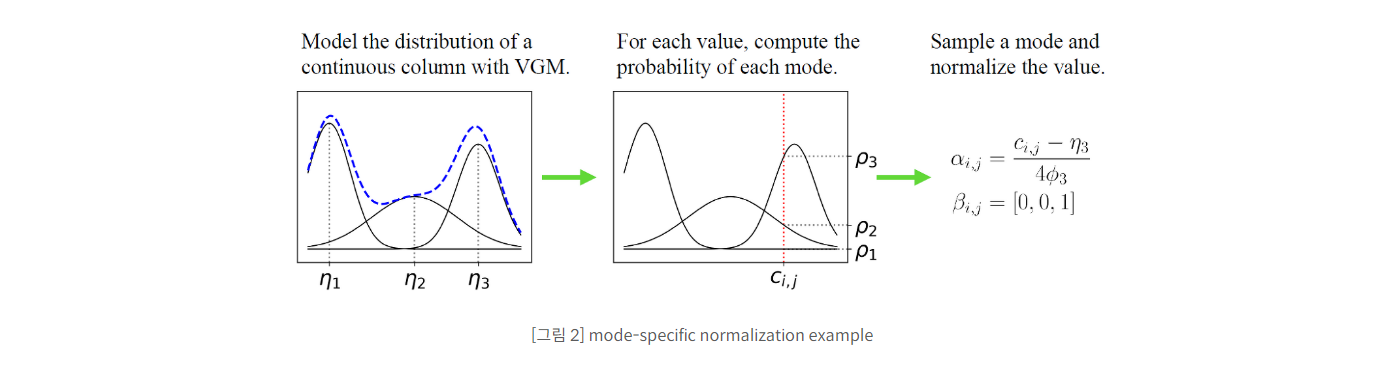

In [4]:
import glob

def preprocessing(input_path):
    all_input_list = sorted(glob.glob(input_path))
    train = pd.DataFrame()
    for datapath in all_input_list:
        data = pd.read_csv(datapath) 
  
        data['obs_time'] = data.index % 24 
        df = abs(data)
        df.loc[(df['내부온도관측치'] > 40), '내부온도관측치'] = 40
        df.loc[(df['내부습도관측치'] > 100), '내부습도관측치'] = 100
        df.loc[(df['co2관측치'] > 1200), 'co2관측치'] = 1200
        df.loc[(df['ec관측치'] > 8), 'ec관측치'] = 8
        df.loc[(df['시간당분무량'] > 3000), '시간당분무량'] = 3000
        df.loc[(df['시간당백색광량'] > 120000), '시간당백색광량'] = 120000
        df.loc[(df['시간당적색광량'] > 120000), '시간당적색광량'] = 120000
        df.loc[(df['시간당청색광량'] > 120000), '시간당청색광량'] = 120000
        df.loc[(df['시간당총광량'] > 120000), '시간당총광량'] = 120000
        df['시간당총광량'] = df['시간당청색광량']+df['시간당백색광량']+df['시간당적색광량']
        
        col_list = df.columns
        for i in range(0,len(col_list)):
            col = col_list[i]    
            if '누적' in col : 
                df[col] = df.groupby((df.obs_time == 0).cumsum()).agg(col_list[i-1]).cumsum()   
            df.to_csv(datapath,index=False)
            train = pd.concat([train,df])
    print('finish!!')
    return train

In [14]:
trainx = preprocessing('drive/MyDrive/dacon/gan/상추/train_input/*.csv')

finish!!


In [15]:
day0 = trainx[trainx['DAT']==0].reset_index(drop=True)
day0 = day0[['obs_time','내부온도관측치','내부습도관측치','co2관측치','ec관측치','시간당분무량','시간당백색광량','시간당적색광량','시간당청색광량']]
day0.describe()

,obs_time,내부온도관측치,내부습도관측치,co2관측치,ec관측치,시간당분무량,시간당백색광량,시간당적색광량,시간당청색광량
count,10752.000000,10752.000000,10752.000000,10752.000000,10752.000000,10752.000000,10752.000000,10752.000000,10752.000000
mean,11.500000,25.781004,54.912360,533.833783,1.273970,430.609479,6765.408458,1309.564887,856.852189
std,6.922508,4.361793,12.257845,144.127605,0.932456,491.308581,9450.283141,2653.722924,1938.172567
min,0.000000,0.000000,0.000000,60.400000,0.000000,0.000000,0.000000,0.000000,0.000000
25%,5.750000,23.595463,49.183641,446.345833,0.401136,0.000000,0.000000,0.000000,0.000000
50%,11.500000,26.280460,56.510000,505.883333,1.212455,242.355000,0.000000,0.000000,0.000000
75%,17.250000,28.717917,61.310767,578.400000,2.011237,769.000000,18255.190000,976.332000,135.110625
max,23.000000,39.158823,81.900001,1200.000000,3.034100,2735.210000,120000.000000,9928.800000,18570.857500


In [7]:
nday0 = pd.get_dummies(data = day0, columns = ['obs_time'], prefix = 'obs_time')

In [ ]:
from sklearn.preprocessing import StandardScaler, MinMaxScaler
sc = MinMaxScaler()

In [ ]:
pip install ctgan

In [16]:
from ctgan import CTGAN
from ctgan import load_demo

real_data = day0

# Names of the columns that are discrete
discrete_columns = [
    'obs_time'
]

ctgan = CTGAN(epochs=10)
ctgan.fit(real_data, discrete_columns)

# Create synthetic data
synthetic_data = ctgan.sample(1000)

In [17]:
real_data.describe()

,obs_time,내부온도관측치,내부습도관측치,co2관측치,ec관측치,시간당분무량,시간당백색광량,시간당적색광량,시간당청색광량
count,10752.000000,10752.000000,10752.000000,10752.000000,10752.000000,10752.000000,10752.000000,10752.000000,10752.000000
mean,11.500000,25.781004,54.912360,533.833783,1.273970,430.609479,6765.408458,1309.564887,856.852189
std,6.922508,4.361793,12.257845,144.127605,0.932456,491.308581,9450.283141,2653.722924,1938.172567
min,0.000000,0.000000,0.000000,60.400000,0.000000,0.000000,0.000000,0.000000,0.000000
25%,5.750000,23.595463,49.183641,446.345833,0.401136,0.000000,0.000000,0.000000,0.000000
50%,11.500000,26.280460,56.510000,505.883333,1.212455,242.355000,0.000000,0.000000,0.000000
75%,17.250000,28.717917,61.310767,578.400000,2.011237,769.000000,18255.190000,976.332000,135.110625
max,23.000000,39.158823,81.900001,1200.000000,3.034100,2735.210000,120000.000000,9928.800000,18570.857500


In [18]:
synthetic_data.describe()

,obs_time,내부온도관측치,내부습도관측치,co2관측치,ec관측치,시간당분무량,시간당백색광량,시간당적색광량,시간당청색광량
count,1000.000000,1000.000000,1000.000000,1000.000000,1000.000000,1000.000000,1000.000000,1000.000000,1000.000000
mean,11.769000,27.047111,53.264076,539.057152,1.380987,337.613306,7638.555987,1668.974091,244.019589
std,6.862414,4.492952,10.598778,163.182149,0.907293,423.169410,7602.314735,3084.300647,991.538056
min,0.000000,13.018688,0.472735,365.794952,-0.078575,-35.873994,-484.896601,-722.618992,-76.761057
25%,6.000000,24.395818,48.936821,433.757678,0.555205,34.734889,30.687902,-43.982104,-17.678053
50%,12.000000,27.041686,55.760282,483.250783,1.334847,128.647276,5269.657073,10.255629,11.828946
75%,18.000000,30.521736,58.706965,572.853165,2.120843,752.540443,17417.501426,1382.845128,40.870406
max,23.000000,35.339033,89.378234,1218.894045,3.196517,2272.060670,20027.605523,11031.556151,10800.992568
